In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Examine table for analysis
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [88]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores


#Note - include 8/23 (1 year + 1 day) to match numbers in instructions
date = dt.datetime(2016, 8, 22)

# query = session.query(Measurement.date, func.max(Measurement.prcp))\
#     .filter(Measurement.date > date).group_by(Measurement.date).all()

query = session.query(Measurement.date,Measurement.prcp)\
    .filter(Measurement.date > date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(query, columns=['date', 'precip'])
#Note - drop NaNs to match numbers in the instructions
df = df.dropna()
df.set_index('date', inplace=True)
df

,precip
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-17,0.13
2017-08-19,0.09
2017-08-21,0.56


<BarContainer object of 2021 artists>

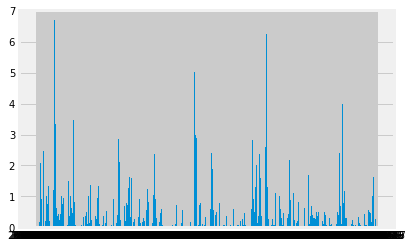

In [97]:
# Use Pandas Plotting with Matplotlib to plot the data

# df.plot.bar()
# plt.tight_layout()
# plt.show()

# **** technically not the plt function (see above)
fig, ax = plt.subplots()
x_axis = df.index
y_axis = df['precip']
ax.bar(x_axis,y_axis)

#****for later - how to get axes labels 
# ax.xlabel = "Date"
# ax.ylabel= "Precipitation"
#****for later - tick control
# y_pos = np.arange(len(df['date'])/12)
# plt.xticks(y_pos, x_axis)
# ax.xaxis.set_visible(False)
# ax.get_xaxis().set_visible(False)
# plt.xlabel = "Date"
#ax.get_xaxis().set_ticks([])

In [76]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# ***** doesn't match exactly count 2021 (vs 2223 with Nans)
df.describe()

,precip
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [98]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [128]:
# Design a query to show how many stations are available in this dataset?
query = session.query(func.count(func.distinct(Measurement.station))).scalar()
print (f"There are {query} stations in the full data set.")
# **** only 7 in 1 year dataset - how capture - need?
# query2 = session.query(func.count(Station.station)).filter(Measurement.date > date).all()
# print (f"There are {query2} stations in 1 year data set.")

# Calculate the Item Totals (sum(UnitPrice * Quantity)) for the USA
# session.query(func.sum(Items.UnitPrice * Items.Quantity)).\
#     filter(Invoices.InvoiceId == Items.InvoiceId).\
#     filter(Invoices.BillingCountry == 'USA').scalar()

# Calculate the Item Totals `sum(UnitPrice * Quantity)` for each Billing Postal Code in the USA
# Sort the results in descending order by Total
# session.query(Invoices.BillingPostalCode, func.sum(Items.UnitPrice * Items.Quantity)).\
#     filter(Invoices.InvoiceId == Items.InvoiceId).\
#     filter(Invoices.BillingCountry == 'USA').\
#     group_by(Invoices.BillingPostalCode).\
#     order_by(func.sum(Items.UnitPrice * Items.Quantity).desc()).all()

There are 9 stations in the full data set.


In [143]:
# What are the most active stations? (i.e. what stations have the most rows)? 
# List the stations and the counts in descending order. Using tobs, not prcp.
query = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
query  

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [148]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
mtobs = Measurement.tobs
query = session.query(func.min(mtobs),func.max(mtobs),func.avg(mtobs)).\
    filter(Measurement.station=='USC00519281').all()
query

[(54.0, 85.0, 71.66378066378067)]

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [25]:
# Plot the daily normals as an area plot with `stacked=False`
